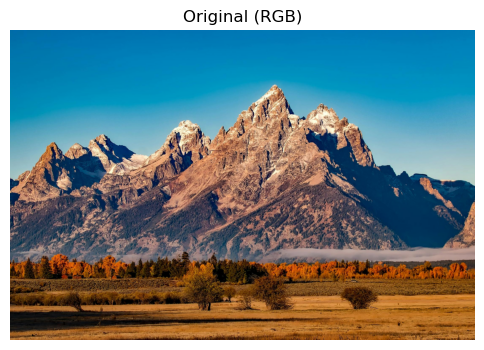

In [1]:
# %%
#  Sharpening an RGB color image with the Laplacian filter mask

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load (change this) ---
img_path = "../image2.jpg"   

img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(img_path)

# Convert to RGB for display and to float [0,1] for math
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_f   = img_rgb.astype(np.float32) / 255.0

def show(img, title="", size=5):
    plt.figure(figsize=(size, size))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
show(img_rgb, "Original (RGB)", size=6)


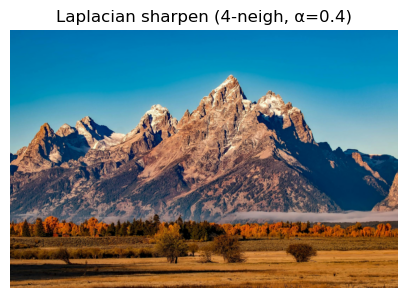

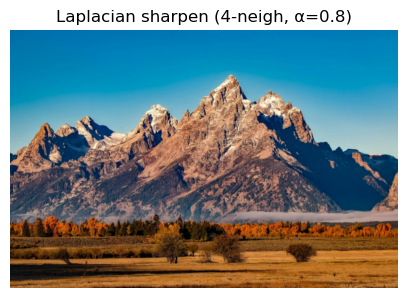

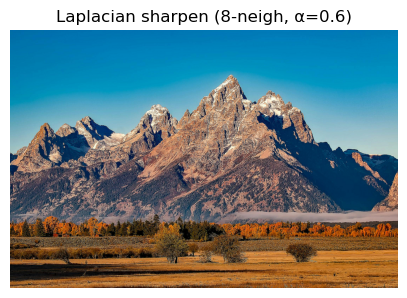

In [2]:
# %%
# Laplacian-based sharpening — core function
# Sharpened = I - alpha * Laplacian(I)
# (Laplacian has positive center, negative neighbors; subtracting it boosts edges.)

def laplacian_sharpen(img01, alpha=0.6, kernel_type="4"):
    """
    img01: float32 RGB in [0,1]
    alpha: sharpening strength (0.3–1.0 typical)
    kernel_type: "4" for 4-neighbor Laplacian, "8" for 8-neighbor Laplacian
    """
    if kernel_type == "8":
        k = np.array([[1, 1, 1],
                      [1,-8, 1],
                      [1, 1, 1]], dtype=np.float32)
    else:  # "4" neighbor (default)
        k = np.array([[0,-1, 0],
                      [-1,4,-1],
                      [0,-1, 0]], dtype=np.float32)

    lap = cv2.filter2D(img01, ddepth=-1, kernel=k, borderType=cv2.BORDER_REFLECT)
    sharp = img01 - alpha * lap
    sharp = np.clip(sharp, 0.0, 1.0)
    return sharp

# Try a few strengths / kernels
sh_4_04 = laplacian_sharpen(img_f, alpha=0.4, kernel_type="4")
sh_4_08 = laplacian_sharpen(img_f, alpha=0.8, kernel_type="4")
sh_8_06 = laplacian_sharpen(img_f, alpha=0.6, kernel_type="8")

show((sh_4_04*255).astype(np.uint8), "Laplacian sharpen (4-neigh, α=0.4)")
show((sh_4_08*255).astype(np.uint8), "Laplacian sharpen (4-neigh, α=0.8)")
show((sh_8_06*255).astype(np.uint8), "Laplacian sharpen (8-neigh, α=0.6)")


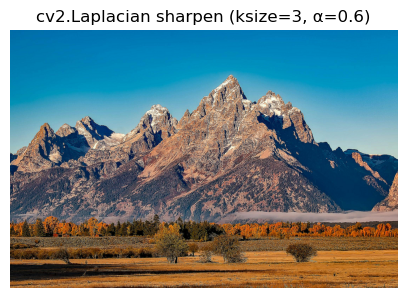

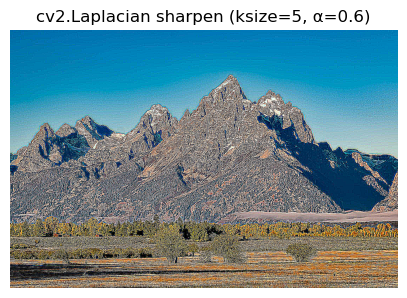

In [3]:
# %%
# Alternative implementation using cv2.Laplacian (same idea, different API)
# This works channel-wise on the color image.

def laplacian_cv_sharpen(img01, alpha=0.6, ksize=3):
    lap = cv2.Laplacian(img01, ddepth=cv2.CV_32F, ksize=ksize, borderType=cv2.BORDER_REFLECT)
    sharp = img01 - alpha * lap
    return np.clip(sharp, 0.0, 1.0)

sh_cv_3 = laplacian_cv_sharpen(img_f, alpha=0.6, ksize=3)
sh_cv_5 = laplacian_cv_sharpen(img_f, alpha=0.6, ksize=5)

show((sh_cv_3*255).astype(np.uint8), "cv2.Laplacian sharpen (ksize=3, α=0.6)")
show((sh_cv_5*255).astype(np.uint8), "cv2.Laplacian sharpen (ksize=5, α=0.6)")


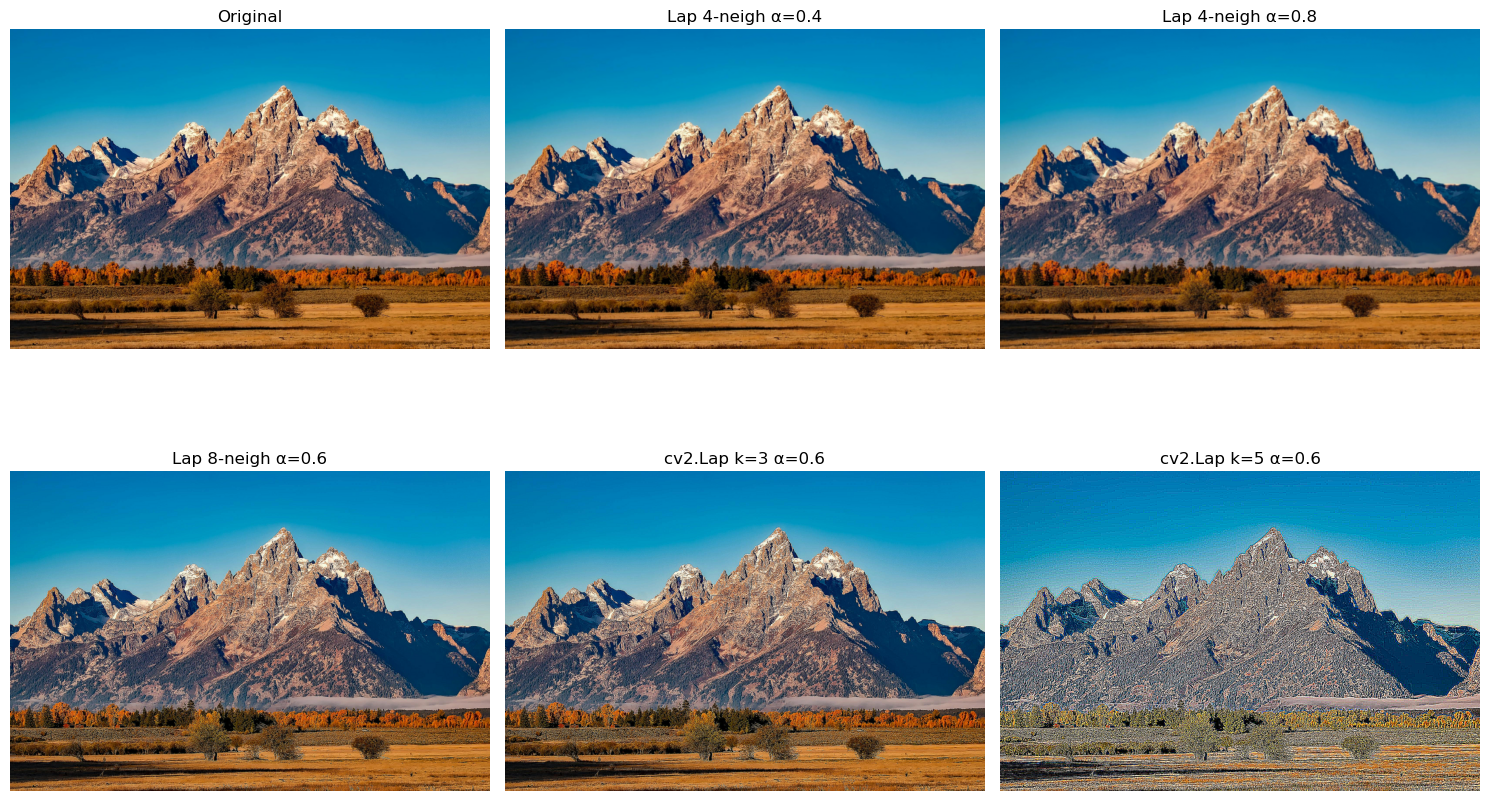

In [4]:
# %%
# Side-by-side comparison grid

pairs = [
    ("Original", img_rgb),
    ("Lap 4-neigh α=0.4", (sh_4_04*255).astype(np.uint8)),
    ("Lap 4-neigh α=0.8", (sh_4_08*255).astype(np.uint8)),
    ("Lap 8-neigh α=0.6", (sh_8_06*255).astype(np.uint8)),
    ("cv2.Lap k=3 α=0.6", (sh_cv_3*255).astype(np.uint8)),
    ("cv2.Lap k=5 α=0.6", (sh_cv_5*255).astype(np.uint8)),
]

cols = 3
rows = int(np.ceil(len(pairs)/cols))
plt.figure(figsize=(15, 5*rows))
for i, (name, im) in enumerate(pairs, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(im)
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()


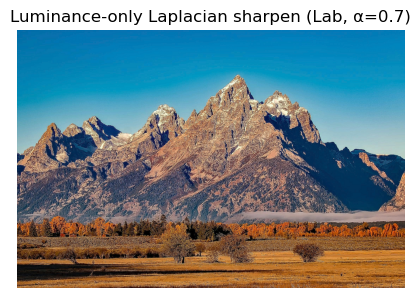

In [5]:


def laplacian_sharpen_lab(img_rgb_u8, alpha=0.6, ksize=3):
    lab = cv2.cvtColor(img_rgb_u8, cv2.COLOR_RGB2LAB).astype(np.float32)
    L, a, b = lab[:,:,0], lab[:,:,1], lab[:,:,2]
    L01 = L / 255.0

    lapL = cv2.Laplacian(L01, ddepth=cv2.CV_32F, ksize=ksize, borderType=cv2.BORDER_REFLECT)
    L_sharp = np.clip(L01 - alpha * lapL, 0.0, 1.0) * 255.0

    lab_sharp = np.stack([L_sharp, a, b], axis=2).astype(np.float32)
    rgb_sharp = cv2.cvtColor(lab_sharp.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return rgb_sharp

lab_sharp = laplacian_sharpen_lab(img_rgb, alpha=0.7, ksize=3)
show(lab_sharp, "Luminance-only Laplacian sharpen (Lab, α=0.7)")
